IP Inversion: Blocks Model (L2)
==========================

## Inverting Pole-Dipole IP Data over a Conductive (and chargeable) and a Resistive Block

For this code comparison, we inverted pole-dipole IP data collected over a conductive and a resistive block. The conductive block was also chargeable. We inverted for an intrinsic chargeability model using a least-squares inversion approach.

For the true model, the background conductivity $\sigma_0$ = 0.01 S/m. The conductor had a conductivity of $\sigma_c$ = 0.1 S/m and an intrinsic chargeability of 0.1 V/V. The resistor had a conductivity of $\sigma_r$ = 0.001 S/m and was non-chargeable. Both blocks were oriented along the Northing direction and have x, y and z dimensions of 400 m, 1600 m and 320 m. Both blocks were buried at a depth of 160 m.

The data being inverted were generated with their respective coding packages. Synthetic apparent chargeability data were simulated with a pole-dipole configuration. The survey consisted of 9 West-East survey lines, each with a length of 2000 m. The line spacing was 250 m and the electrode spacing was 100 m. Gaussian noise with a standard deviation of 1e-6 V + 5% the absolute value were added to each datum. Uncertainties of 1e-6 V + 5% were assigned to the data for inversion.

## Codes/Formulations Being Compared

**SimPEG 3D Nodal Formulation:** This approach to solving the forward problem uses the *SimPEG.electromagnetics.static.induced_polarization.simulation.Simulation3DNodal* simulation class.

**UBC-GIF DCIP OcTree:** [DCIP OcTree](https://dcipoctree.readthedocs.io/en/latest/) is a voxel cell DC/IP forward modeling and inversion package developed by the UBC Geophysical Inversion Facility. This software is proprietary and can ONLY be acquired through appropriate [commerical](https://gif.eos.ubc.ca/software/licenses_commercial) licenses. The numerical approach of the forward simulation is described in the [online manual's theory section](https://dcipoctree.readthedocs.io/en/latest/content/theory.html). If you have a valid license, there are instructions for reproducing the results (add link).

## Loading Assets Into the SimPEG Framework

We start by importing any necessary packages for running the notebook.

In [1]:
from SimPEG.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
    plot_3d_pseudosection,
    apparent_resistivity,
    apparent_resistivity_from_voltage,
    convert_survey_3d_to_2d_lines
)
from SimPEG.utils.io_utils import read_dcipoctree_ubc, write_dcipoctree_ubc
from SimPEG import maps
from discretize import TreeMesh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

Next we download the mesh, true model, recovered model, predicted data and observed data for each coding package/formulation.

In [2]:
# For each package, download .tar files

For each coding package/formulation, the assets are loaded into the SimPEG framework

In [3]:
# SimPEG result
rootdir = './../../../assets/dcip/block_model_ip_inv_simpeg_octree/'
meshfile = rootdir + 'octree_mesh.txt'
truechgfile = rootdir + 'true_model.chg'
trueconfile = rootdir + 'true_model.con'
chgfile = rootdir + 'recovered_model.chg'
dobsfile = rootdir + 'dobs_simpeg.txt'
dpredfile = rootdir + 'dpred.txt'

mesh_simpeg = TreeMesh.readUBC(meshfile)
true_conductivity_simpeg = TreeMesh.readModelUBC(mesh_simpeg, trueconfile)
true_chargeability_simpeg = TreeMesh.readModelUBC(mesh_simpeg, truechgfile)
recovered_chargeability_simpeg = TreeMesh.readModelUBC(mesh_simpeg, chgfile)
data_simpeg = read_dcipoctree_ubc(dobsfile, 'apparent_chargeability')
dpred_simpeg = read_dcipoctree_ubc(dpredfile, 'apparent_chargeability')

# DCIP octree result
rootdir = './../../../assets/dcip/block_model_ip_inv_ipoctree/'
meshfile = rootdir + 'octree_mesh.txt'
chgfile = rootdir + 'inv_02.chg'
dobsfile = rootdir + 'ip_data.dobs'
dpredfile = rootdir + 'dpred_ip_02.txt'

mesh_ubc = TreeMesh.readUBC(meshfile)
recovered_chargeability_ubc = TreeMesh.readModelUBC(mesh_ubc, chgfile)
data_ubc = read_dcipoctree_ubc(dobsfile, 'apparent_chargeability')
dpred_ubc = read_dcipoctree_ubc(dpredfile, 'apparent_chargeability')

## Plotting the True Model and Survey Geometry

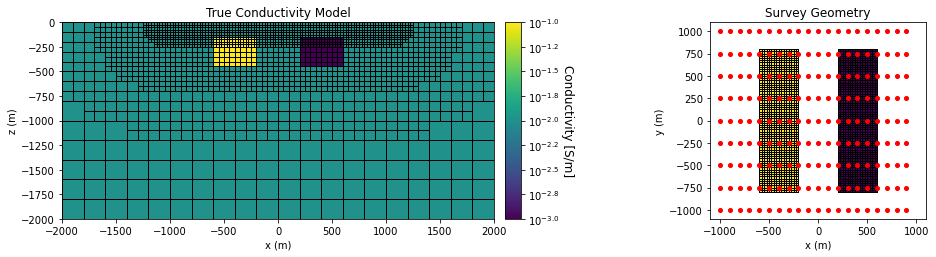

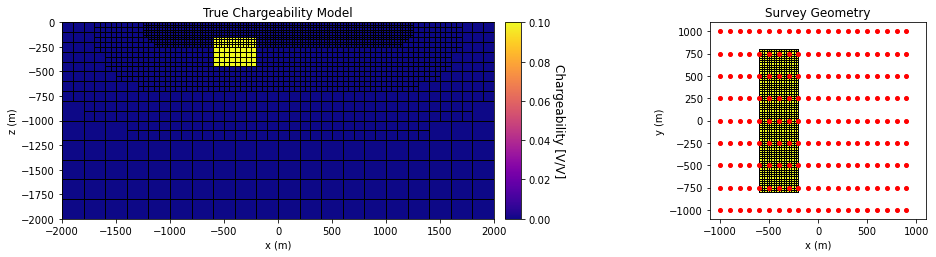

In [4]:
vmin = np.log10(true_conductivity_simpeg.min())
vmax = np.log10(true_conductivity_simpeg.max())
ind = int(len(mesh_simpeg.hy)/2)

fig = plt.figure(figsize=(15, 3.5))

ax1 = fig.add_axes([0.1, 0.12, 0.4, 0.78])
mesh_simpeg.plot_slice(
    np.log10(true_conductivity_simpeg), ax=ax1, normal='Y', grid=True,
    ind=ind, clim=(vmin, vmax), pcolorOpts={"cmap": "viridis"},
)
ax1.set_xlim([-2000, 2000])
ax1.set_ylim([-2000, 0])
ax1.set_title("True Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.51, 0.12, 0.015, 0.78])
norm = mpl.colors.Normalize(
    vmin=vmin, vmax=vmax
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, cmap=mpl.cm.viridis, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

ax3 = fig.add_axes([0.7, 0.12, 0.2, 0.78])
ind = int(len(mesh_simpeg.hz)-10)
masked_model = np.log10(true_conductivity_simpeg)
masked_model[masked_model==-2]=np.NaN
mesh_simpeg.plot_slice(
    masked_model, ax=ax3, normal='Z', grid=True,
    ind=ind, clim=(vmin, vmax), pcolorOpts={"cmap": "viridis"},
)
for ii in range(0, 9):
    ax3.plot(np.arange(-1000, 1000, 100), -1000+ii*250*np.ones(20), 'ro', markersize=4)
ax3.set_xlim([-1100, 1100])
ax3.set_ylim([-1100, 1100])
ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')
ax3.set_title('Survey Geometry')

plt.show()

vmin = true_chargeability_simpeg.min()
vmax = true_chargeability_simpeg.max()
ind = int(len(mesh_simpeg.hy)/2)

fig = plt.figure(figsize=(15, 3.5))

ax1 = fig.add_axes([0.1, 0.12, 0.4, 0.78])
mesh_simpeg.plot_slice(
    true_chargeability_simpeg, ax=ax1, normal='Y', grid=True,
    ind=ind, clim=(vmin, vmax), pcolorOpts={"cmap": "plasma"},
)
ax1.set_xlim([-2000, 2000])
ax1.set_ylim([-2000, 0])
ax1.set_title("True Chargeability Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.51, 0.12, 0.015, 0.78])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, cmap=mpl.cm.plasma, orientation="vertical"
)
cbar.set_label("Chargeability [V/V]", rotation=270, labelpad=15, size=12)

ax3 = fig.add_axes([0.7, 0.12, 0.2, 0.78])
ind = int(len(mesh_simpeg.hz)-10)
masked_model = true_chargeability_simpeg.copy()
masked_model[masked_model<vmax]=np.NaN
mesh_simpeg.plot_slice(
    masked_model, ax=ax3, normal='Z', grid=True,
    ind=ind, clim=(vmin, vmax), pcolorOpts={"cmap": "plasma"},
)
for ii in range(0, 9):
    ax3.plot(np.arange(-1000, 1000, 100), -1000+ii*250*np.ones(20), 'ro', markersize=4)
ax3.set_xlim([-1100, 1100])
ax3.set_ylim([-1100, 1100])
ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')
ax3.set_title('Survey Geometry')

plt.show()

## Comparing Recovered Models

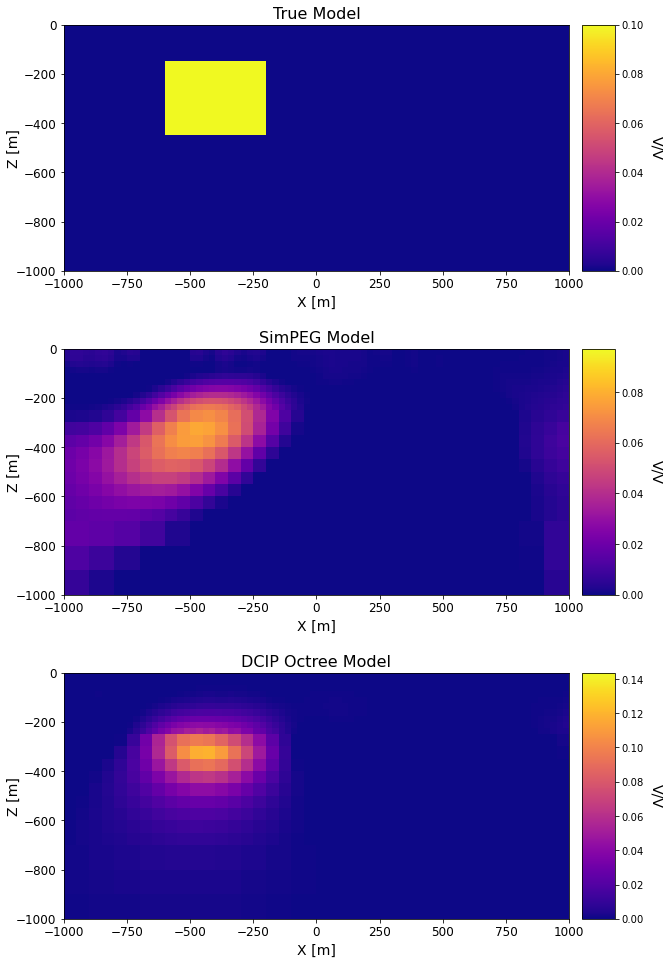

In [5]:
fig = plt.figure(figsize=(9, 9))
font_size = 14

models_list = [
    true_chargeability_simpeg, recovered_chargeability_simpeg, recovered_chargeability_ubc
]
titles_list = ['True Model', 'SimPEG Model', 'DCIP Octree Model']
ax1 = 3*[None]
cplot = 3*[None]
ax2 = 3*[None]
cbar = 3*[None]

for qq in range(0, 3):
    ax1[qq] = fig.add_axes([0.1, 0.55 - 0.5*qq, 0.78, 0.38])
    
    cplot[qq] = mesh_simpeg.plot_slice(
        models_list[qq], normal='Y', ind=int(len(mesh_simpeg.hy)/2), grid=False,
        ax=ax1[qq], pcolorOpts={"cmap": "plasma"}
    )
    cplot[qq][0].set_clim((np.min(models_list[qq]), np.max(models_list[qq])))
    ax1[qq].set_xlim([-1000, 1000])
    ax1[qq].set_ylim([-1000, 0])
    ax1[qq].set_xlabel("X [m]", fontsize=font_size)
    ax1[qq].set_ylabel("Z [m]", fontsize=font_size, labelpad=-5)
    ax1[qq].tick_params(labelsize=font_size - 2)
    ax1[qq].set_title(titles_list[qq], fontsize=font_size + 2)
    
    ax2[qq] = fig.add_axes([0.9, 0.55 - 0.5*qq, 0.05, 0.38])
    norm = mpl.colors.Normalize(vmin=np.min(models_list[qq]), vmax=np.max(models_list[qq]))
    cbar[qq] = mpl.colorbar.ColorbarBase(
        ax2[qq], norm=norm, orientation="vertical", cmap=mpl.cm.plasma
    )
    cbar[qq].set_label(
        "V/V",
        rotation=270,
        labelpad=20,
        size=font_size,
)

plt.show()

## Comparing Misfit Maps

Here we convert the 3D data into a set of 2D survey lines. For easier interpretation, the voltage data are converted to apparent conductivities.

In [6]:
survey_simpeg = data_simpeg.survey
line_id = np.zeros(survey_simpeg.nD)
northing = np.unique(survey_simpeg.locations_a[:, 1])

for ii in range(0, len(northing)):
    line_id[survey_simpeg.locations_a[:, 1] == northing[ii]] = ii

survey_2d_list = convert_survey_3d_to_2d_lines(survey_simpeg, line_id, 'apparent_chargeability')

data_list_simpeg = [
    data_simpeg.dobs, dpred_simpeg.dobs, (data_simpeg.dobs - dpred_simpeg.dobs) / data_simpeg.standard_deviation
]
data_list_ubc = [
    data_ubc.dobs, dpred_ubc.dobs, (data_ubc.dobs - dpred_ubc.dobs) / data_ubc.standard_deviation
]

Here we plot the observed apparent conductivities, predicted apparent conductivities and normalized misfits in 2D pseudosection for a given pole-dipole line.

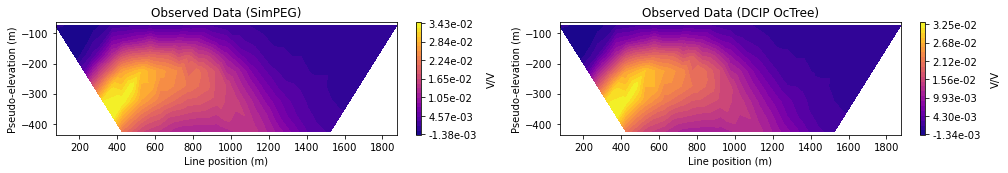

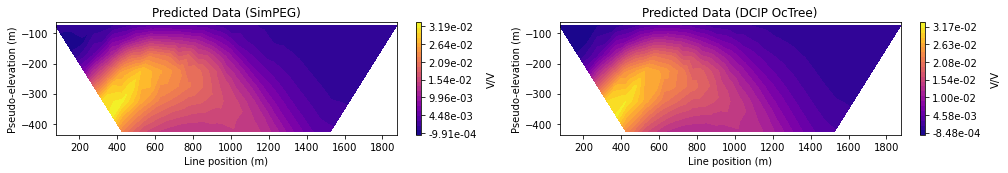

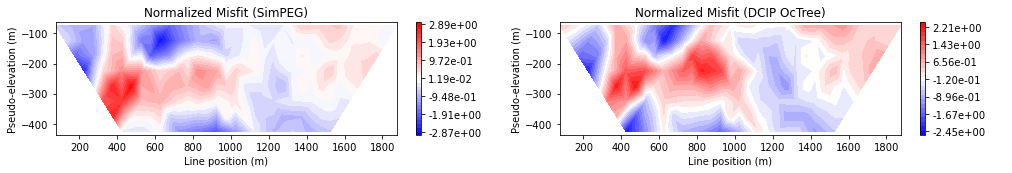

In [7]:
IND = 4
title_str = ['Observed Data', 'Predicted Data', 'Normalized Misfit']
cmap_list = [mpl.cm.plasma, mpl.cm.plasma, mpl.cm.bwr]
label_list = ["V/V", "V/V", " "]

for ii in range(0, 3):

    fig = plt.figure(figsize=(14, 2))
    
    ax1 = fig.add_axes([0.05, 0.15, 0.38, 0.78])
    plot_pseudosection(
        survey_2d_list[IND],
        dobs=data_list_simpeg[ii][line_id==IND],
        plot_type="contourf",
        ax=ax1,
        scale='lin',
        cbar_label=label_list[ii],
        contourf_opts={"levels": 30, "cmap": cmap_list[ii]},
    )
    ax1.set_title(title_str[ii] + ' (SimPEG)')
    
    ax2 = fig.add_axes([0.55, 0.15, 0.38, 0.78])
    plot_pseudosection(
        survey_2d_list[IND],
        dobs=data_list_ubc[ii][line_id==IND],
        plot_type="contourf",
        ax=ax2,
        scale='lin',
        cbar_label=label_list[ii],
        contourf_opts={"levels": 30, "cmap": cmap_list[ii]},
    )
    ax2.set_title(title_str[ii] + ' (DCIP OcTree)')
    
    plt.show()